In [117]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LassoCV 

Computing the solution to the minimization problem, in the $d=1, n=1$ case:

In [149]:
def simple_minimization(lmbda, x, y):
    if x*y > lmbda:
        return ((x*y) - lmbda) / (x**2)
    elif x*y < -lmbda:
        return ((x*y) + lmbda) / (x**2)
    elif np.absolute(x*y) <= lmbda:
        return 0
    else:
        print('Invalid arguments.')

Verification via comparison with a graph of $F(\beta)$, where $x=1, y=1, \lambda=1$:

Computed value for optimal Beta: 0.00


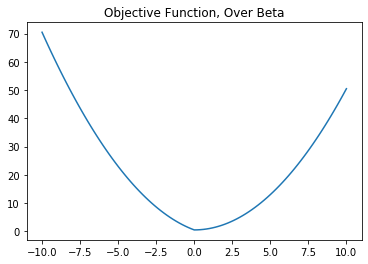

In [35]:
x, y, lmd = 1, 1, 1
B = np.linspace(start=-10, stop=10, num=101)
F = 0.5*(y-x*B)**2 + lmd*np.absolute(B)

sol = simple_minimization(lmd, x, y)
print('Computed value for optimal Beta: %.2f' % sol)

plt.plot(B,F)
plt.title('Objective Function, Over Beta')
plt.show()

Verficiation via comparison with a graph of $F(\beta)$, where $x=-1, y=-1, \lambda=-1$:

Computed value for optimal Beta: 2.00


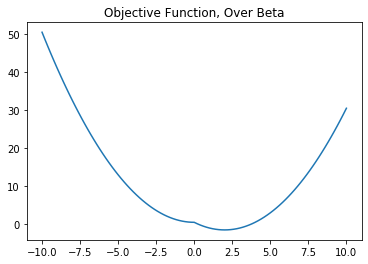

In [32]:
x, y, lmd = -1, -1, -1
B = np.linspace(start=-10, stop=10, num=101)
F = 0.5*(y-x*B)**2 + lmd*np.absolute(B)

sol = simple_minimization(lmd, x, y)
print('Computed value for optimal Beta: %.2f' % sol)

plt.plot(B,F)
plt.title('Objective Function, Over Beta')
plt.show()

In both cases, we see that the function returns the same value for $\beta$ at which the minimum occurs in the corresponding plot. 

Now we move to the $d > 1, n > 1$ case. 

In [150]:
def partial_minimization(B, lmbda, X, y, j):
    sum = 0
    
    for i in range(len(X)):
        sum += simple_minimization(lmbda, X[i][j], y[i])
        
    sum /= (2*len(X))
    return sum         

We retrieve the data:

In [151]:
# access
hitters = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv', sep=',', header=0)
hitters = hitters.dropna()

# split 
y = hitters.Salary.to_numpy()
del hitters['Salary']

# standardize 
league = pd.get_dummies(hitters.League, prefix='league')
div = pd.get_dummies(hitters.Division)
new_league = pd.get_dummies(hitters.NewLeague, prefix='new_league')

del hitters['League']
del hitters['Division']
del hitters['NewLeague']

hitters = hitters.join(league)
hitters = hitters.join(div)
hitters = hitters.join(new_league)
hitters = hitters.to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(hitters)

We have the additional functions:

In [197]:
def computeobj(B, lmbda, X, y):
    risk = (1/(2*len(X))) * np.sum((y-X.dot(B))**2)
    penalty = lmbda * np.linalg.norm(B, ord=1) 
    return risk + penalty 

In [192]:
def cycliccoorddescent(B_init, lmbda, X, y, max_iter=1000):
    B = B_init
    Bs = B
    t = 0
    j = 0 
    
    while t < max_iter:
        B[j] = partial_minimization(B[j], lmbda, X, y, j)
        Bs = np.vstack((Bs, B))
        j = 0 if (j == X.shape[1]-1) else (j+1)
        t += 1 
        
    return Bs 

In [188]:
def pickcoord(d):
    # because we sample from {1...d}, we must -1 where function is called 
    return np.random.randint(1,d+1)

In [189]:
def randcoorddescent(B_init, lmbda, X, y, max_iter=1000):
    B = B_init
    Bs = B
    t = 0 
    j = 0 
    
    while t < max_iter:
        j = pickcoord(X.shape[1]) - 1
        B[j] = partial_minimization(B[j], lmbda, X, y, j)
        Bs = np.vstack((Bs, B))
        t += 1
    
    return Bs 

Optimal $\lambda$ via sklearn:

In [190]:
lcv = LassoCV()
lcv.fit(X,y)
lmbda = lcv.alpha_
print('Optimal lambda is %.2f' % lmbda)

Optimal lambda is 2.74


Training:

In [194]:
B_init = np.zeros(X.shape[1])
Bs_cyclic = cycliccoorddescent(B_init, lmbda, X, y)
Bs_random = randcoorddescent(B_init, lmbda, X, y)

Plotting:

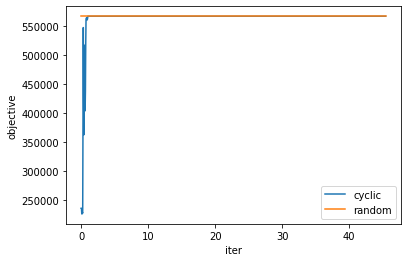

In [198]:
def objective_plot(c, r):
    d = c.shape[1]
    t = np.arange(len(c)) / d
    
    c_objs = []
    r_objs = []
    
    for B in c:
        o = computeobj(B, lmbda, X, y)
        c_objs.append(o)
    
    for B in r:
        o = computeobj(B, lmbda, X, y)
        r_objs.append(o)
    
    plt.plot(t, c_objs, label='cyclic')
    plt.plot(t, r_objs, label='random')
    plt.xlabel('iter')
    plt.ylabel('objective')
    plt.legend()
    plt.show()
    
objective_plot(Bs_cyclic, Bs_random)   

We notice entirely impractical results, largely due to large $\beta$ values which increasingly grow the objective function values. However, random descent does not follow this pattern, and instead demonstrates negligble change in objective value. This is likely due to an unresolved issue in the partial_minimization computation, which itself relies on simple_minimization as coded above. 

Comparison with sklearn:

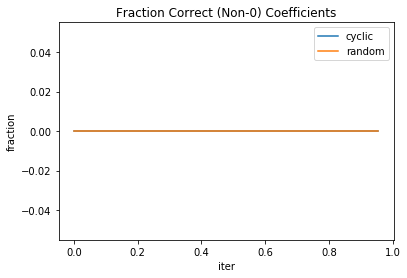

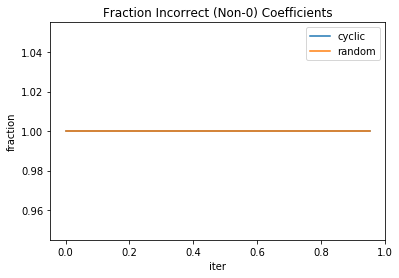

In [209]:
def comparison_plot(c, r, correct=False):
    B_star = lcv.coef_
    
    t = []
    c_correct = []
    r_correct = []
    
    for i in range(len(B_star)):
        Bc = c[i]
        Br = r[i]
        
        c_idxs = np.where(Bc != 0)
        r_idxs = np.where(Br != 0)
        
        Bc = Bc[c_idxs]
        Br = Br[r_idxs]
        
        c_correct.append(np.mean(B_star[c_idxs] == Bc))
        r_correct.append(np.mean(B_star[r_idxs] == Br))
        t.append(i/len(B_star))
    
    if not correct:
        c_correct = [1-x for x in c_correct]
        r_correct = [1-x for x in r_correct]
        
    title = 'Fraction Correct (Non-0) Coefficients' if correct else 'Fraction Incorrect (Non-0) Coefficients'
    
    plt.plot(t, c_correct, label='cyclic')
    plt.plot(t, r_correct, label='random')
    plt.xlabel('iter')
    plt.ylabel('fraction')
    plt.legend()
    plt.title(title)
    plt.show()

comparison_plot(Bs_cyclic, Bs_random, correct=True)
comparison_plot(Bs_cyclic, Bs_random)

A programming isse again prevents us from seeing the plotted fraction of correct (or incorrect) non-zero coefficient counts, when our algorithms are compared to $\beta_\star$ from sklearn.

Hopefully, we would see the fraction in the 'correct' plot rise for both algorithms, and fall in the 'incorrect' plot, since after every 'pass' (t/d passes) the weights vector should be closer to the reliable sklearn result. It is hypothesized that the cyclic descent may align with sklearn faster, because all $\beta_j$ are updated uniformly, wheras there may be many redundant updates in random descent that do not improve the performance.

Note also that an assumption was made, in that at every state, non-zero coefficients referred to non-zero values in our two algorithm's $\beta$, since via coordinate descent many iterations may see mostly 0 values in our weights vector. 